# Data Can be found here:

https://github.com/VHRanger/Graph-Data

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, minmax_scale
import seaborn as sns
import sys
import warnings
sys.path.append(os.path.realpath('..'))

# Nodevectors can be installed from pip (my node2vec lib)
import nodevectors

# UMAP embedding as a baseline (pip install umap-learn)
import umap

# From the related karateclub lib (on pip)
from karateclub.node_embedding.neighbourhood import GraRep, NodeSketch, Walklets
from karateclub import GraphReader

# I added small this graph library
import csrgraph as cg
from csrgraph import methods
from nodevectors.evaluation import graph_eval

# Introduction

This work researches approaches to graph embedding based on the [GLoVe](https://nlp.stanford.edu/pubs/glove.pdf) algorithm rather than word2vec based approaches (eg. deepwalk, node2vec).

### Why?

I believe this approach can lead to a much more efficient graph embedding algorithm (eg. an order of magnitude +++ in speed, space and scalability).

The GLoVe algorithm can be done directly on the graph object in terms of Gradient descent + elementary graph operations. Word2vec-based approaches work by embedding through word2vec on random walks (where walks are analoguous of sentences in NLP training)

### GLoVe recap

GLoVe works directly on the the word co-occurence matrix. Note that a word co-occurence matrix can be directly re-interpreted as a graph object (in its adjacency matrix).

The embeddings are the weight matrix $W$ which minimize the loss function in equation (8) in the paper:

$Loss = \sum_{i,j} f(X_{i,j})(w_i^T w_j + b_i + b_j - ln X_{i,j})^2$

The weight matrix has row entry per word (node) and one column per embedding dimension. A word (node) $i$'s embedding is the corresponding row $W_i$ (the bias vector $b$ is discarded).

Note that the loss function from GLoVe is equivalent to the loss function in word2vec (equation 16 in GLoVe following arguments in section 3.1). GLoVe and Word2Vec should produce the same results when trained on the same initial data.

### GLoVe problems on network data

Consider a graph with no edge weights (eg. an adjacency matrix where values are 1 where there's an edge and 0 otherwise). Here, most terms disappear from the GLoVe loss equation (8):

$f(X_{i,j}) = 0$

$ln X_{i,j} = 0$

$Loss = \sum_{i,j} (w_i^T w_j + b_i + b_j)^2$

We can reinterpret GLoVe as minimizing the dot product between nodes' vectors if they have edges joining them. The terms $f(X_{i,j})$ and $ln X_{i,j}$ are only terms to handle weighing edge weights in the loss function.

The GLoVe loss function is specifically tuned for a co-occurence matrix where some words appear often together in the training corpus (eg. $W_{i,j} > 1 often for non-zero entries) so it's not well suited for generic graph data.

### GLoVe / word2vec problems more generally

Because GLoVe / word2Vec (equivalent loss function) function by minimizing the dot product between related nodes, it works only as a contraction towards the origin $0^d$ of the vector space in which we're embedding.

Consider the degenerate case of a zero'ed out initial weight matrix $W_{i,j} = 0 \forall (i, j \in W)$. Then, the training will stop immediately: the dot product is already 0 between all nodes, so there's no further improvement to be found.

More generally, the problem with the GLoVe/Word2Vec is that because it's a contraction towards the origin from the initial training weights, it "bunches" the resulting embeddings somwhere near the origin (see plots below). 

This is an inefficient use of the vector space -- you need to have more dimensions in the vector space to "separate out" nodes. So in cases where $d=2$ or $d=3$ then all nodes cluster together -- you need many more dimensions to the embedding vector space for nodes clusters to be separable from each other.

# Questions:

1) Is there a way to improve the GLoVe loss function for graphs specifically?

This function would need to deal with graphs with no edge weights effectively while also respecting the structure of graphs with arbitrary real-valued edge weights 

2) Is there a way to eliminate the "bunching problem"?

If we keep with the dot product objective, then the loss function would need not only to minimize the dot product between connected nodes, but also somehow train towards increased dot product between disconnected nodes.

This would create an embedding which is less dense at the origin and hence have a better use of each embedding dimension

3) Can we exploit graph structure for training?

For instance, we can augment a classic bag-of-words co-occurence matrix with tf-idf. Similarly, we could use the pagerank or the degree of each node as an additional node weight in training. This would be easy to implement (just multiply the graph adjacency matrix by the pagerank or degree vector before training GLoVe then train normally)

# plots

I generate a highly clustered graph and visualize the result of GLoVe, node2vec and UMAP embeddings. We see thast GLoVe and node2vec "bunch up" towards the origin, whereas UMAP creates a much better embedding.

UMAP ([paper](https://arxiv.org/abs/1802.03426), [code](https://github.com/lmcinnes/umap))is already a decent alternative for network data. It embeds arbitrary matrices, including the adjacency matrix of a graph. The only problem is that the algorithm is necessarily much more complex and slow(even though it's fast enough in many use cases)  than direct dot-product minimization like we're doing.

UMAP is very good at reprocuding cluster structure with few dimensions. GLoVe and Node2Vec reproduce the cluster somewhat, but since we're visualizing in 2 or 3d, they use the vector space poorly and bunch all nodes up towards the center.

In [2]:
# G, labels = graph_eval.make_cluster_graph(n_nodes=820, n_clusters=18, connections=1000, drop_pct=0.5)
# G, labels = graph_eval.make_weighed_cluster_graph(n_nodes=400, n_clusters=6, connections=1500, drop_pct=0.2, max_edge_weight=15)
# G, labels = graph_eval.make_blogcatalog(dedupe=True)
G, labels = graph_eval.make_email()

N_COMPONENTS = 3

In [3]:
def draw_weights(w, min_val=-1.1, max_val=1.1):
    """Draw embeddings in 2 or 3d"""
    if w.shape[1] == 2:
        plt.clf()
        to_draw = pd.DataFrame(w).reset_index(drop=False)
        to_draw.columns = ['idx', 'x', 'y']
        ax = sns.scatterplot('x', 'y', data=to_draw, 
            hue='idx', palette=node_palette, legend=False)
        ax.set(ylim=(min_val, max_val), 
               xlim=(min_val, max_val))
        plt.show()
    elif w.shape[1] == 3:
        plt.clf()
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter3D(w[:, 0], w[:, 1], w[:, 2], c=node_palette)
        ax.set(ylim=(min_val, max_val), 
               xlim=(min_val, max_val), 
               zlim=(min_val, max_val))
        plt.show()
    else:
        raise ValueError(f"Not 2 or 3d, got {w.shape}")

y = labels.label
n_clusters = y.nunique()

X_train, X_test, y_train, y_test = train_test_split(
    labels.node, y, test_size=0.10, random_state=33)

palette = sns.color_palette('rainbow', y.nunique())
node_palette = list(labels.label.map(lambda x: palette[x]))
print("original network")
if len(G) < 500:
    nx.draw_spring(G, node_size=50, node_color=node_palette)

original network


Loss: 0.1698	:   5%|▌         | 325/6000 [00:04<01:12, 78.09it/s]  


Converged! Loss: 0.1717


<Figure size 432x288 with 0 Axes>

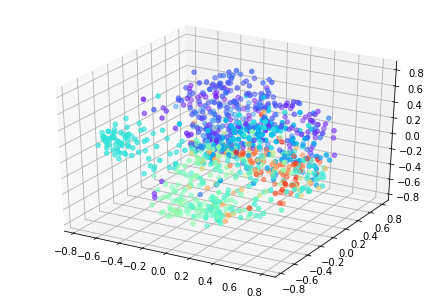

<Figure size 432x288 with 0 Axes>

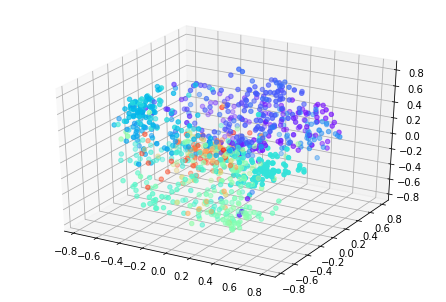

<Figure size 432x288 with 0 Axes>

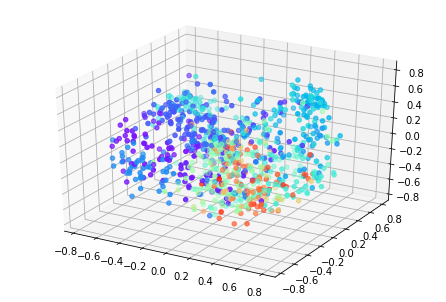

<Figure size 432x288 with 0 Axes>

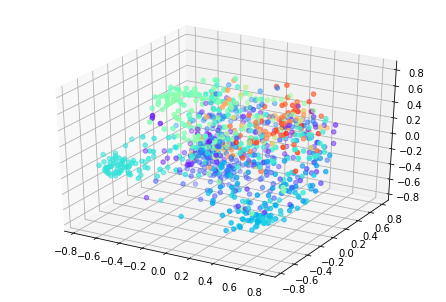

In [4]:
ggvec = nodevectors.GGVec(
    n_components=N_COMPONENTS,
    tol_samples=200,
    tol=0.05,
    learning_rate=0.01,
    negative_ratio=0.6,
    max_epoch=6000,
    verbose=True
)
ggw = ggvec.fit_transform(G)

draw_weights(ggw, min_val=ggw.min(), max_val=ggw.max())
if N_COMPONENTS > 2:
    draw_weights(ggw * np.array([-1, 1, 1]), min_val=ggw.min(), max_val=ggw.max())
    draw_weights(ggw * np.array([1, -1, 1]), min_val=ggw.min(), max_val=ggw.max())
    draw_weights(ggw * np.array([1, 1, -1]), min_val=ggw.min(), max_val=ggw.max())

Making walks... Done, T=2.33
Mapping Walk Names... Done, T=1.38
Training W2V... Done, T=25.18


<Figure size 432x288 with 0 Axes>

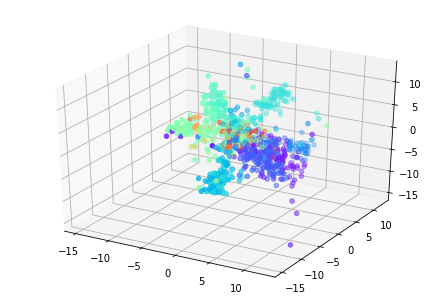

<Figure size 432x288 with 0 Axes>

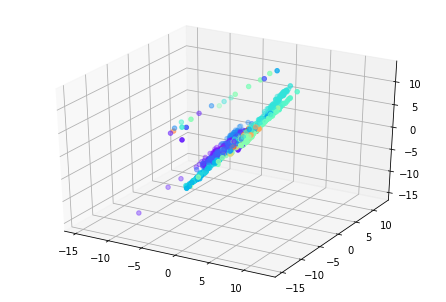

<Figure size 432x288 with 0 Axes>

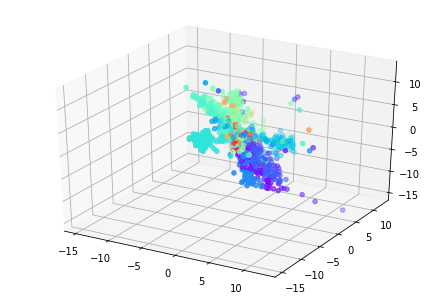

<Figure size 432x288 with 0 Axes>

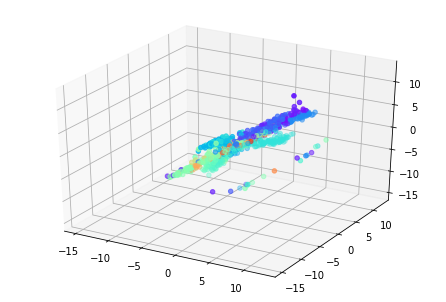

In [5]:
n2v = nodevectors.Node2Vec(
    walklen=30, epochs=50,
    return_weight=1.,
    n_components=N_COMPONENTS
)
n2vembeds = n2v.fit_transform(G)

draw_weights(n2vembeds, min_val=n2vembeds.min(), max_val=n2vembeds.max())
if N_COMPONENTS > 2:
    draw_weights(n2vembeds * np.array([-1, 1, 1]), min_val=n2vembeds.min(), max_val=n2vembeds.max())
    draw_weights(n2vembeds * np.array([1, -1, 1]), min_val=n2vembeds.min(), max_val=n2vembeds.max())
    draw_weights(n2vembeds * np.array([1, 1, -1]), min_val=n2vembeds.min(), max_val=n2vembeds.max())

### NOTE:

Node2Vec/Deepwalk methods always create these filamented structures, poorly using #dims

<Figure size 432x288 with 0 Axes>

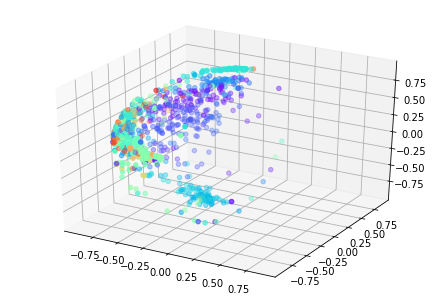

<Figure size 432x288 with 0 Axes>

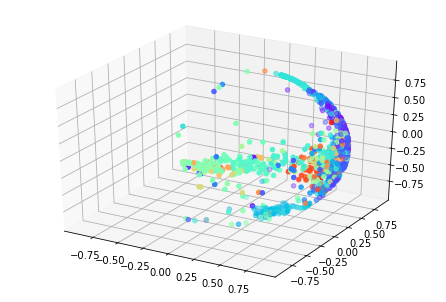

<Figure size 432x288 with 0 Axes>

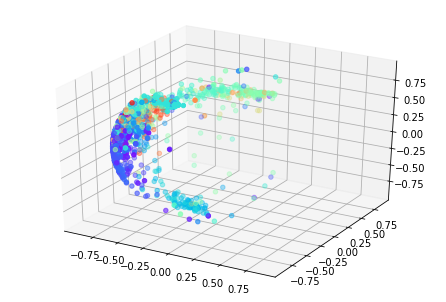

<Figure size 432x288 with 0 Axes>

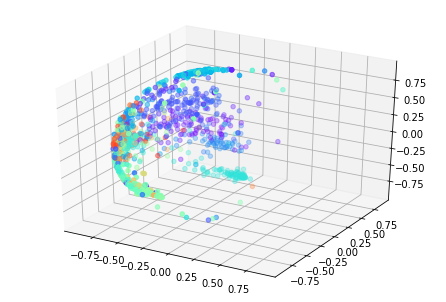

In [6]:
pne = nodevectors.ProNE(
    n_components=N_COMPONENTS,
    mu=0.5, 
    theta=0.5,
)
pw = pne.fit_transform(G)

draw_weights(pw, min_val=pw.min(), max_val=pw.max())
if N_COMPONENTS > 2:
    draw_weights(pw * np.array([-1, 1, 1]), min_val=pw.min(), max_val=pw.max())
    draw_weights(pw * np.array([1, -1, 1]), min_val=pw.min(), max_val=pw.max())
    draw_weights(pw * np.array([1, 1, -1]), min_val=pw.min(), max_val=pw.max())

<Figure size 432x288 with 0 Axes>

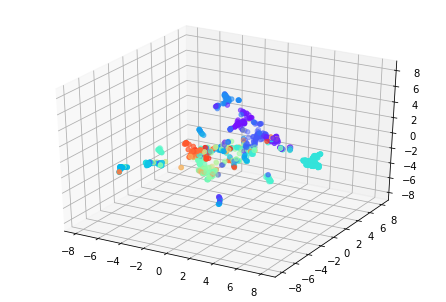

<Figure size 432x288 with 0 Axes>

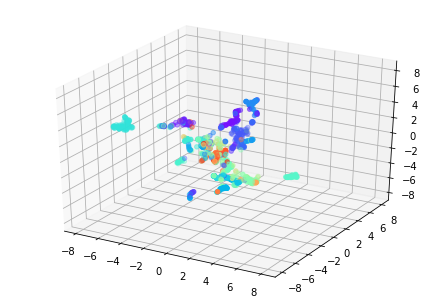

<Figure size 432x288 with 0 Axes>

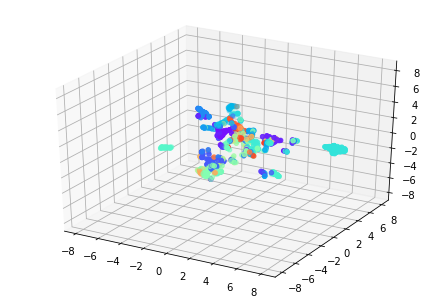

<Figure size 432x288 with 0 Axes>

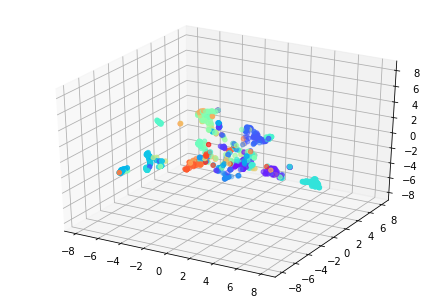

In [19]:
ump = nodevectors.SKLearnEmbedder(
    umap.UMAP, 
    n_components=N_COMPONENTS,
    n_neighbors=5,
    metric='cosine',
    
)
umpmbeds = ump.fit_transform(G)

draw_weights(umpmbeds, min_val=umpmbeds.min(), max_val=umpmbeds.max())
if N_COMPONENTS > 2:
    draw_weights(umpmbeds * np.array([-1, 1, 1]), min_val=umpmbeds.min(), max_val=umpmbeds.max())
    draw_weights(umpmbeds * np.array([1, -1, 1]), min_val=umpmbeds.min(), max_val=umpmbeds.max())
    draw_weights(umpmbeds * np.array([1, 1, -1]), min_val=umpmbeds.min(), max_val=umpmbeds.max())

100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


<Figure size 432x288 with 0 Axes>

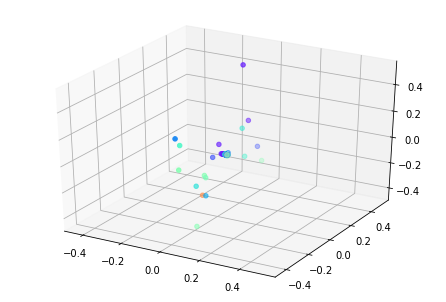

<Figure size 432x288 with 0 Axes>

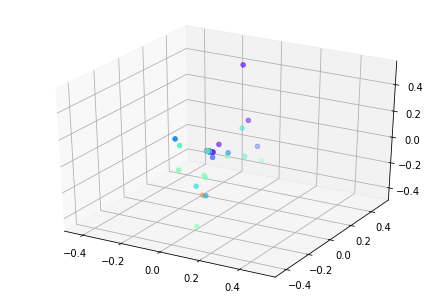

<Figure size 432x288 with 0 Axes>

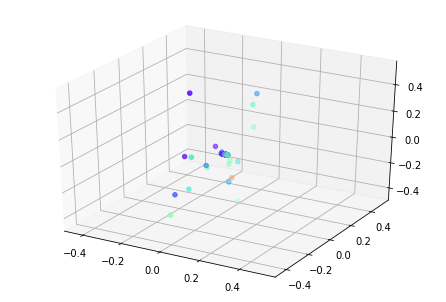

<Figure size 432x288 with 0 Axes>

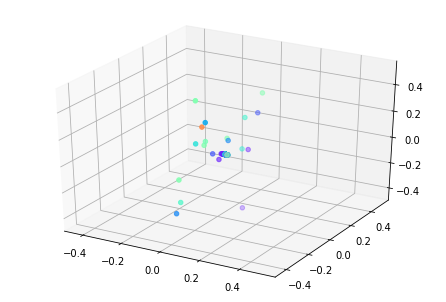

In [21]:
grep = nodevectors.GraRep(
    n_components=N_COMPONENTS,
    order=3,
#     merger=(lambda x : np.mean(x, axis=0)),
    merger=lambda x : x[-1]
)
grw = grep.fit_transform(G)

draw_weights(grw, min_val=grw.min(), max_val=grw.max())
if N_COMPONENTS > 2:
    draw_weights(grw * np.array([-1, 1, 1]), min_val=grw.min(), max_val=grw.max())
    draw_weights(grw * np.array([1, -1, 1]), min_val=grw.min(), max_val=grw.max())
    draw_weights(grw * np.array([1, 1, -1]), min_val=grw.min(), max_val=grw.max())